# Estrategias con opciones

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

## 0. Gráficos de profit and loss para opciones

Recordemos como realizar los gráficos de ganancia/pérdida

In [3]:
def call_payoff(ST, K):
    return max(0, ST-K)

In [4]:
def call_pnl_combined(ct, K, STmin, STmax, step = 1):
    maturities = np.arange(STmin, STmax+step, step)
    payoffs = np.vectorize(call_payoff)(maturities, K)
    df = pd.DataFrame({'Strike': K, 'Payoff': payoffs, 'Prima': ct, 'PnLcomprador': payoffs-ct, 'PnLvendedor': ct-payoffs}, index=maturities)
    df.index.name = 'Precio de maduración'
    return df

In [5]:
call_pnl_combined(12, 15, 10, 35)

,Payoff,PnLcomprador,PnLvendedor,Prima,Strike
Precio de maduración,,,,,
10,0,-12,12,12,15
11,0,-12,12,12,15
12,0,-12,12,12,15
13,0,-12,12,12,15
14,0,-12,12,12,15
...,...,...,...,...,...
31,16,4,-4,12,15
32,17,5,-5,12,15
33,18,6,-6,12,15


In [21]:
def put_payoff(ST, K):
    return max(0, K-ST)

In [22]:
def put_pnl_combined(ct, K, STmin, STmax, step = 1):
    maturities = np.arange(STmin, STmax+step, step)
    payoffs = np.vectorize(put_payoff)(maturities, K)
    df = pd.DataFrame({'Strike': K, 'Payoff': payoffs, 'Prima': ct, 'PnLcomprador': payoffs-ct, 'PnLvendedor': ct-payoffs}, index=maturities)
    df.index.name = 'Precio de maduración'
    return df

In [23]:
put_pnl_combined(2, 15, 10, 30)

,Payoff,PnLcomprador,PnLvendedor,Prima,Strike
Precio de maduración,,,,,
10,5,3,-3,2,15
11,4,2,-2,2,15
12,3,1,-1,2,15
13,2,0,0,2,15
14,1,-1,1,2,15
...,...,...,...,...,...
26,0,-2,2,2,15
27,0,-2,2,2,15
28,0,-2,2,2,15


In [6]:
def plot_pnl(pnl_df, okind, who):
    if who=='comprador':
        plt.ylim(pnl_df.PnLcomprador.min()-3, pnl_df.PnLcomprador.max()+3)
        plt.plot(pnl_df.index, pnl_df.PnLcomprador)
    elif who=='vendedor':
        plt.ylim(pnl_df.PnLvendedor.min()-3, pnl_df.PnLvendedor.max()+3)
        plt.plot(pnl_df.index, pnl_df.PnLvendedor)
    else:
        print('el parámetro who debe ser comprador o vendedor')
        return
    plt.ylabel("Ganancia/pérdida")
    plt.xlabel("Precio de maduración")
    plt.title('Ganancia y pérdida de una opción {0} para el {1}, Prima={2}, Strike={3}'.format(okind, who, pnl_df.Prima.iloc[0],
    pnl_df.Strike.iloc[0]))
    plt.xlim(pnl_df.index[0], pnl_df.index[len(pnl_df.index)-1])
    plt.axhline(0, color='g');

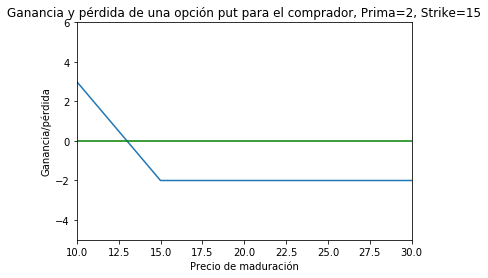

In [24]:
plot_pnl(put_pnl_combined(2, 15, 10, 30), "put", "comprador")

## 1. Motivación

Referencia:
- Introducción a los Mercados de Futuros y Opciones, Octava Ed., J. C. Hull, 2014.

Ya vimos como luce el patrón de ganancia/pérdida proveniente de una inversión con una sola opción. Ahora veremos cómo lucen estos gráficos de ganancia/pérdida cuando se involucran más activos.

En particular, analizaremos dos opciones sobre un mismo activo.

¿Porqué se querría hacer esto? La respuesta es que las elecciones particulares dependen del juicio que se haga acerca de cómo se desplazarán los precios y de la disposición para asumir riesgos.

## 2. Diferenciales de precios

También conocidos como *SPREADS*. Una estrategia de negociación de diferenciales implica tomar una posición en dos o más opciones del mismo tipo.

### 2.1 Diferenciales alcistas (bull spreads)

- Es uno de los diferenciales más comunes.
- Se crea mediante:
    - adquisición (posición larga) en una opción de compra sobre una acción con cierto precio de ejercicio $K_1$;
    - emisión (posición corta) en una opción de compra sobre la misma acción con un precio de ejercicio más alto $K_2>K_1$;
    - ambas opciones tienen la misma fecha de expiración.
- La utilidad de la totalidad de la estrategia es la suma de las totalidades individuales.
- Como el precio de una opción de compra disminuye cuando se aumenta el precio de ejercicio (justificar), la prima de la posición corta siempre es menor a la prima de la posición larga. Se requiere inversión inicial.

**Ejemplo (11.2 del Hull)** Un inversionista adquiere en $\$3$ una opción de compra a tres meses con un precio de ejercicio de $\$30$, y vende en $\$1$ una opción de compra a tres meses con un precio de $\$35$. El beneficio derivado de esta estrategia de diferencial alcista es de $\$5$ si el precio de la acción esta por encima de $\$35$ y de cero si está por debajo de $\$30$. Si el precio de la acción está entre $\$30$ y $\$35$, el beneficio es la cantidad en la cual el precio de ejercicio excede a $\$30$. El costo de la estategia es de $\$2$, por tanto la utilidad es de 

Primero veamos para la opciones por separado

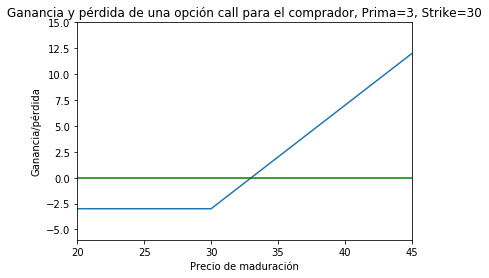

In [14]:
plot_pnl(call_pnl_combined(3, 30, 20, 45), "call", "comprador")

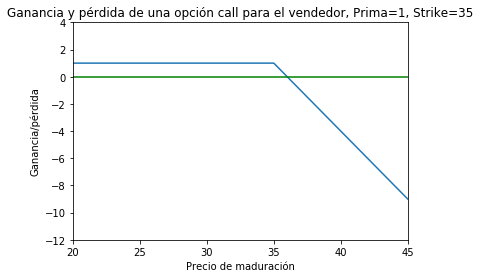

In [15]:
plot_pnl(call_pnl_combined(1, 35, 20, 45), "call", "vendedor")

Ahora, creamos la función para la estrategia bull con opciones de compra

In [9]:
def bull_call(ct_short, K_short, ct_long, K_long, STmin, STmax, step = 1):
    maturities = np.arange(STmin, STmax+step, step)
    payoffs_cl = np.vectorize(call_payoff)(maturities, K_long)
    payoffs_cs = np.vectorize(call_payoff)(maturities, K_short)
    df = pd.DataFrame({'Strike': K_long, 'Payoff': payoffs_cs, 'Prima': ct_long-ct_short, 'PnL': payoffs_cl-ct_long+(ct_short-payoffs_cs)}, index=maturities)
    df.index.name = 'Precio de maduración'
    return df

In [10]:
def plot_pnl_str(pnl_df, strat, okind):
    plt.ylim(pnl_df.PnL.min()-3, pnl_df.PnL.max()+3)
    plt.plot(pnl_df.index, pnl_df.PnL)
    plt.ylabel("Ganancia/pérdida")
    plt.xlabel("Precio de maduración")
    plt.title('Ganancia y pérdida de una estrategia {0} con opciones {1}'.format(strat, okind))
    plt.xlim(pnl_df.index[0], pnl_df.index[len(pnl_df.index)-1])
    plt.axhline(0, color='g');

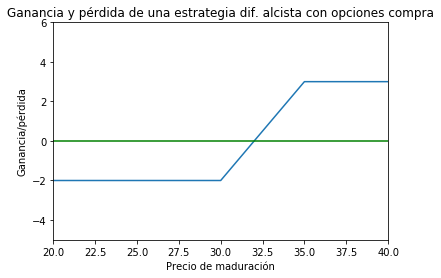

In [11]:
plot_pnl_str(bull_call(1, 35, 3, 30, 20, 40), 'dif. alcista', 'compra')

Notamos que se limita el potencial de aumento en la utilidad, pero también se limita el riesgo. Requiere inversión inicial pero provee un beneficio nulo o positivo.

También se puede crear un diferencial alcista mediante:
- adquisición (posición larga) en una opción de venta sobre una acción con cierto precio de ejercicio $K_1$;
- emisión (posición corta) en una opción de venta sobre la misma acción con un precio de ejercicio más alto $K_2>K_1$;

A diferencia de la estrategia diferencial alcista con opciones de compra provee un flujo de efectivo por adelantado, pero el beneficio es nulo o negativo.

**Si la expectativa de que el precio de la acción baje, se usa una estrategia diferencial bajista (bear spread)**
- Se crean con los precios de ejercicio contrario a como se eligen en la estrategia alcista.

**Tarea.** Obtener una gráfica como la anterior para el ejemplo 11.3 del Hull. 

## 3. Simulación Montecarlo y Estrategias

In [12]:
def get_historical_closes(ticker, start_date, end_date=None):
    #closes = web.YahooDailyReader(ticker, start_date, end_date).read().sort_index('major_axis')
    closes = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date).read()
    closes.set_axis(closes.loc['date',:,ticker[0]].values, axis=1, inplace=True)
    closes = closes.loc['adjclose'].sort_index().dropna()
    closes = pd.DataFrame(np.array(closes.as_matrix(), dtype=np.float64), columns=ticker, index=closes.index)
    closes.index.name = 'Date'
    #return closes.loc['Adj Close']
    return closes

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

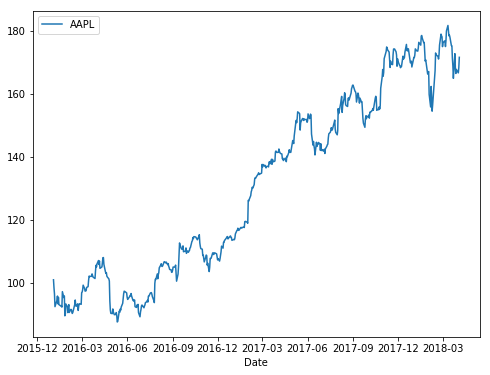

In [13]:
closes_aapl = get_historical_closes(['AAPL'], '2016-01-01')
closes_aapl.plot(figsize=(8,6));

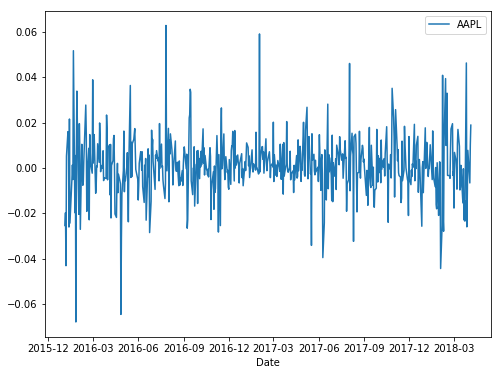

In [14]:
ret_aapl = calc_daily_ret(closes_aapl)
ret_aapl.plot(figsize=(8,6));

In [15]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(ret_aapl)
ndays = (datetime(2018,6,15).date()-datetime(2018,4,4).date()).days
nscen = 10000
K1 = 160
K2 = 180

In [16]:
dates = pd.date_range('2018-04-04',periods=ndays).astype('str')
ret = kde.sample(n_samples=ndays*nscen, random_state=None)
sim_ret_kernel = pd.DataFrame(ret.reshape((ndays, nscen)),index= dates)
sim_closes_kernel = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret_kernel.cumsum())

In [18]:
ST_kernel = sim_closes_kernel.tail(1)
ind = np.digitize(ST_kernel.values[0],np.array([0, K1, K2, ST_kernel.values.max()+1]))
freq = (np.array([sum(ind==1),sum(ind==2),sum(ind==3)])/nscen)*100

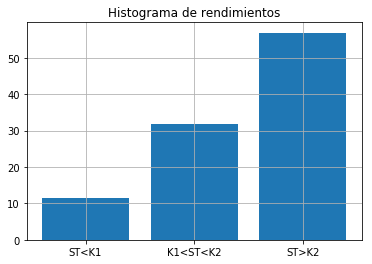

In [19]:
bar_labels = ['ST<K1', 'K1<ST<K2', 'ST>K2']
x_pos = list(range(len(bar_labels)))
plt.bar(x_pos,freq);
plt.title('Histograma de rendimientos')
plt.grid();
plt.xticks(x_pos, bar_labels);

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>